In [1]:
from profiler.core import *

In [2]:
pf = Profiler(workers=2, verbose=False, tol=0.01, eps=0.1)

In [3]:
#pf.session.load_data(name='flights', src='file', fpath='/Users/zhihan/Documents/bart/data/clean_data/flights.csv', embedtxt=False)
pf.session.load_data(name='hospital', src='file', fpath='data/hospital.csv', embedtxt=False)

INFO:profiler.utility:[0.007876157760620117] Load Data start

INFO:profiler.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "Address2": "categorical",
    "Address3": "categorical",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'ProviderNumber': ['equal'], 'HospitalName': ['equal'], 'Address1': ['equal'], 'Address2': ['equal'], 'Address3': ['equal'], 'City': ['equal'], 'State': ['equal'], 'ZipCode': ['equal'], 'CountyName': ['equal'], 'PhoneNumber': ['equal'], 'Hospi

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State'], 
                         ['categorical', 'numeric', 'categorical', 'text'])

INFO:profiler.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.dataset:updated types of State to 'text'
INFO:profiler.dataset:updated operators of State to ['equal']
INFO:profiler.dataset:updated inferred operators of attributes: {'ProviderNumber': ['equal'], 'HospitalName': ['equal'], 'Address1': ['equal'], 'Address2': ['equal'], 'Address3': ['equal'], 'City': ['equal'], 'State': ['equal'], 'ZipCode': ['equal'], 'CountyName': ['equal'], 'PhoneNumber': ['equal'], 'HospitalType': ['equal'], 'HospitalOwner': ['equal'], 'EmergencyService': ['equal'], 'Condition': ['equal'], 'MeasureCode': ['equal'], 'MeasureName': ['equal'], 'Score': ['equal'

In [5]:
# TODO save embedding vectors
# pf.session.load_embedding()

In [6]:
pf.session.load_training_data()

INFO:profiler.utility:[0.10641002655029297] Create Training Data start

INFO:profiler.transformer:needs multiplier = 54 to bound the error in inv cov estimation <= 0.10000000
INFO:profiler.transformer:use multiplier = 54, and the bound is 0.00024939
INFO:profiler.transformer:Draw Pairs
100%|██████████| 19/19 [00:00<00:00, 154.14it/s]
INFO:profiler.transformer:Number of training samples: 56943
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0034
INFO:profiler.utility:[0.6646490097045898] Create Training Data execution time: 0.5582389831542969



In [7]:
# pf.session.learn_structure(sparsity=0.1)
s = pf.session.struct_engine
data = pf.session.training_data
s.n = pf.session.sample_size

In [8]:
s.est_cov = s.estimate_covariance(data.values, pf.session.null_pb, data.columns)

INFO:profiler.graph:use threshold 0.0584


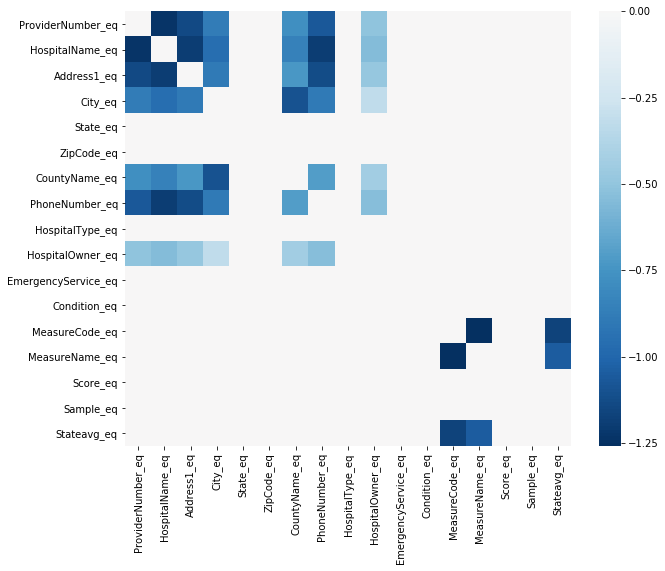

In [11]:
s.param['sparsity'] = 0.1
s.inv_cov = s.estimate_inverse_covariance(s.est_cov.values, data.columns)